In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import time
import argparse
import os
import rasterio



In [14]:
os.chdir('/Users/bgl/Ensta/3a/pfe/hedgedex/hedgedexv4.1/scripts')

from model import *
from utils import jaccard_index_prob, jaccard_loss, mcc, f1_score, overall_accuracy
from config import config
from config import MODEL_CONFIGS

os.chdir('/Users/bgl/Ensta/3a/pfe/hedgedex/hedgedexv4.1')

In [7]:
# Connect to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
# Visualize results
def try_model(model, img_path, eval_metric, selected_bands):
    """
    Display one test image, the corresponding ground truth, and the model prediction
    """
    with rasterio.open(img_path) as src:
        # Read the image data
        raster = src.read()
        # Read the image metadata
        band_names = src.descriptions

    # Extract input channels
    indices = [band_names.index(band) for band in selected_bands]
    image = raster[indices, :, :].astype(np.float32)
    label = raster[-1, :, :].astype(np.float32)

    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension
    label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0).to(device)

    # Perform forward pass
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)[1]
        score = eval_metric(output, label_tensor).item()
        print('Score (Jaccard index) :', score)

    # Post-process the output (e.g., thresholding)
    threshold = 0.3
    output_thresh = (torch.sigmoid(output) > threshold).float()

    # Convert output to numpy array for visualization
    output_thresh_np = output_thresh.squeeze().cpu().numpy()
    output_np = output.squeeze().cpu().numpy()

    # Build an image with TP, TF, FP, FN
    # Initialize an RGB image with the same height and width, and 3 channels for RGB
    results = np.zeros((256, 256, 3), dtype=np.uint8)

    # Define the colors
    color_tp = [200, 255, 200]  # Green for true positives
    color_fn = [0, 0, 255]  # Blue for false negatives
    color_fp = [255, 0, 0]  # Red for false positives
    color_tn = [0, 0, 0]  # Black for true negatives

    # Create the image
    for i in range(256):
        for j in range(256):
            if output_thresh_np[i, j] == 1 and label[i, j] == 1:
                results[i, j] = color_tp
            elif output_thresh_np[i, j] == 0 and label[i, j] == 1:
                results[i, j] = color_fn
            elif output_thresh_np[i, j] == 1 and label[i, j] == 0:
                results[i, j] = color_fp
            elif output_thresh_np[i, j] == 0 and label[i, j] == 0:
                results[i, j] = color_tn


    # Get RGB composite
    rgb_indices = [band_names.index(band) for band in ['B4', 'B3', 'B2']]
    rgb = raster[rgb_indices, :, :].astype(np.float32)

    mx = np.max(rgb)
    rgb = (rgb) / (mx)

    # Display input RGB image, labels, and predictions
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(rgb.transpose(1, 2, 0))
    axs[0].set_title('Input Image')
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('Ground Truth')
    axs[2].imshow(output_thresh_np, cmap='gray')
    axs[2].set_title('Prediction')
    axs[3].imshow(results)
    axs[3].set_title('Confusion Matrix')
    plt.show()
    plt.close(fig)




In [19]:
img_path = '/Users/bgl/Ensta/3a/pfe/hedgedex/data/dataset05/dataset05/img9917.tif'
model_path  = '/Users/bgl/Ensta/3a/pfe/hedgedex/hedgedexv4.1/output/models/model_47459451_bs8_lr0.0001_epochs100_bands5_jaccard_loss_pretrainedFalse.pth'

In [24]:
config.defrost()
config.merge_from_file('test_config.yaml')
config.freeze()
model = get_seg_model(config, n_channels=5, pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
print('Model initialized.')


Model initialized.


Score (Jaccard index) : 0.3267272412776947


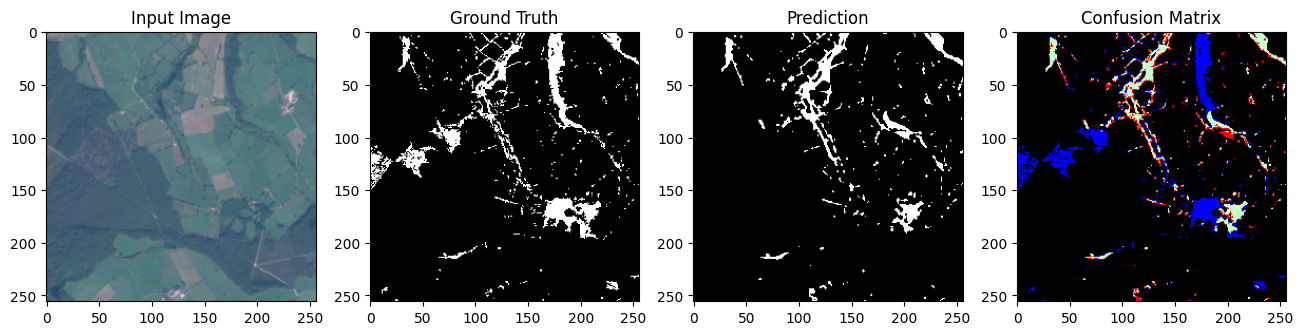

In [25]:
metric = jaccard_index_prob
five_bands = ['B2', 'B3', 'B4', 'B8', 'ndvi']
nine_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ndvi']
try_model(model, img_path, metric, selected_bands=five_bands)